In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import ddn.pytorch.robustpool as robustpool

import urllib
from urllib.request import urlretrieve
from pathlib import Path

import pytorch_lightning as pl

%matplotlib inline
import matplotlib.pyplot as plt

_ = pl.seed_everything(42)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
DATASET_ROOT = Path("Architectural_Heritage_Elements_Dataset_128(creative_commons)")
ARCHIVE_NAME = Path("architectural_heritage_elements.zip")

if not ARCHIVE_NAME.is_file():
    print("Downloading...")
    urlretrieve(
        "https://datahub.ckan.io/dataset/b3dba928-c6f5-431e-90d0-3bb86e8f42a2/resource/aed19d35-9e7a-4ec3-9234-187dffb5484f/download/architecturalheritageelementsdataset128creativecommons.zip",
        ARCHIVE_NAME)

if not DATASET_ROOT.is_dir():
    print("Unzipping...")
    import zipfile
    with zipfile.ZipFile(ARCHIVE_NAME, 'r') as archive:
        archive.extractall(".")


In [3]:
def get_datasets():
    dataset_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ])

    dataset = torchvision.datasets.ImageFolder(DATASET_ROOT, transform=dataset_tf)
    train_len = int(len(dataset) * 0.7)
    val_len = len(dataset) - train_len
    
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_len, val_len])
    
    return train_dataset, val_dataset

In [4]:
class LitSqueezeNet(pl.LightningModule):

    def __init__(self, n_classes):
        super().__init__()
        self._model = torchvision.models.squeezenet1_0(pretrained=False)
        self._model.classifier[1] = nn.Conv2d(512, n_classes, kernel_size=(1,1), stride=(1,1))
        
        self._best_model = None
        self._best_val_loss = np.inf
        
        self._train_epoch_loss = 0
        self._train_epoch_n_predictions = 0
        
        self._val_epoch_loss = 0
        self._val_epoch_n_predictions = 0
        
        self._criterion = nn.CrossEntropyLoss()
        
        self._train_accuracy = pl.metrics.Accuracy()
        self._val_accuracy = pl.metrics.Accuracy()
    
    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        return self._model.forward(x)

    def training_step(self, batch, batch_idx):
        # training_step defined the train loop. It is independent of forward
        x, y = batch
        y_hat = self._model.forward(x)
        loss = self._criterion(y_hat, y)
        train_step_acc = self._train_accuracy(y_hat, y)
        self._train_epoch_loss += loss.item() * y.shape[0]
        self._train_epoch_n_predictions += y.shape[0]
        return loss
    
    def training_epoch_end(self, outs):
        epoch_loss = self._train_epoch_loss / self._train_epoch_n_predictions
        self._train_epoch_loss = 0
        self._train_epoch_n_predictions = 0
        self.logger.log_metric('train_loss_epoch', epoch_loss)
        self.logger.log_metric('train_acc_epoch', self._train_accuracy.compute())
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self._model.forward(x)
        loss = self._criterion(y_hat, y)
        val_step_acc = self._val_accuracy(y_hat, y)
        self._val_epoch_loss += loss.item() * y.shape[0]
        self._val_epoch_n_predictions += y.shape[0]
        return loss
    
    def validation_epoch_end(self, outs):
        epoch_loss = self._val_epoch_loss / self._val_epoch_n_predictions
        self._val_epoch_loss = 0
        self._val_epoch_n_predictions = 0
        self.logger.log_metric('val_loss_epoch', epoch_loss)
        self.logger.log_metric('val_acc_epoch', self._val_accuracy.compute())
        if epoch_loss < self._best_val_loss:
            self._best_val_loss = epoch_loss
            torch.save(self._model.state_dict(), "best_model.pth.tar")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-4)
        return optimizer

In [5]:
train_dataset, val_dataset = get_datasets()

In [6]:
model = LitSqueezeNet(n_classes=10)

neptune_logger = pl.loggers.neptune.NeptuneLogger(project_name="timeescaper/cvx-proj", 
                                                  experiment_name="squeezenet_basic")

trainer = pl.Trainer(gpus=1,
                     max_epochs=200,
                     logger=neptune_logger)

trainer.fit(model, 
            train_dataloader=torch.utils.data.DataLoader(train_dataset, batch_size=128, num_workers=4),
            val_dataloaders=torch.utils.data.DataLoader(val_dataset, batch_size=128, num_workers=4))

https://ui.neptune.ai/timeescaper/cvx-proj/e/CVXPROJ-23


NeptuneLogger will work in online mode
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params
-----------------------------------------------------
0 | _model          | SqueezeNet       | 740 K 
1 | _criterion      | CrossEntropyLoss | 0     
2 | _train_accuracy | Accuracy         | 0     
3 | _val_accuracy   | Accuracy         | 0     


1

In [7]:
best_model = torchvision.models.squeezenet1_0(pretrained=False)
best_model.classifier[1] = nn.Conv2d(512, 10, kernel_size=(1,1), stride=(1,1))
best_model.load_state_dict(torch.load("best_model_squeezenet.pth.tar"))
best_model = best_model.to(DEVICE)
best_model = best_model.eval()

In [8]:
def evaluate_model(model, dataset):
    n_predictions = 0
    n_correct = 0

    for x, y in torch.utils.data.DataLoader(dataset, batch_size=128, num_workers=4):
        y_pred = torch.argmax(model.forward(x.to(DEVICE)), dim=1).cpu()
        n_correct += (y_pred == y).sum().item()
        n_predictions += y.shape[0]
    
    return n_correct / n_predictions

In [12]:
best_model_acc = evaluate_model(best_model, val_dataset)
print(best_model_acc)

0.8277434060566591


In [13]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    # perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [14]:
def test( model, test_loader, epsilon ):

    # Accuracy counter
    correct = 0

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(DEVICE), target.to(DEVICE)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc

In [17]:
epsilons = [0.005, 0.01, 0.05, 0.1, 0.2, 0.3]
# epsilons = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
best_model_attack_accs = []
for eps in epsilons:

    result = test(best_model, 
                  torch.utils.data.DataLoader(val_dataset, batch_size=1, num_workers=4),
                  eps)
    best_model_attack_accs.append(result)

Epsilon: 0.005	Test Accuracy = 1929 / 3071 = 0.6281341582546401
Epsilon: 0.01	Test Accuracy = 1421 / 3071 = 0.46271572777596875
Epsilon: 0.05	Test Accuracy = 592 / 3071 = 0.1927710843373494
Epsilon: 0.1	Test Accuracy = 569 / 3071 = 0.18528166720937805
Epsilon: 0.2	Test Accuracy = 541 / 3071 = 0.17616411592315206
Epsilon: 0.3	Test Accuracy = 484 / 3071 = 0.15760338651904918


In [87]:
torch.mean(val_dataset[2][0])

tensor(-0.1057)

## Robust Pooling

In [30]:
class LitRobustSqueezeNet(pl.LightningModule):
    
    FEATURE_VECTOR_SIZE = 512

    def __init__(self, n_classes):
        super().__init__()
        self._features = torchvision.models.squeezenet1_0(pretrained=False).features
        self._pooling = robustpool.RobustGlobalPool2d(robustpool.Welsch)
        self._classifier = nn.Sequential(
            nn.Linear(512, 100),
            nn.ReLU(),
            nn.Linear(100, n_classes))
        
        self._best_model = None
        self._best_val_loss = np.inf
        
        self._train_epoch_loss = 0
        self._train_epoch_n_predictions = 0
        
        self._val_epoch_loss = 0
        self._val_epoch_n_predictions = 0
        
        self._criterion = nn.CrossEntropyLoss()
        
        self._train_accuracy = pl.metrics.Accuracy()
        self._val_accuracy = pl.metrics.Accuracy()
    
    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        x = self._features.forward(x)
        x = self._pooling.forward(x)
        x = self._classifier.forward(x)
        return x

    def training_step(self, batch, batch_idx):
        # training_step defined the train loop. It is independent of forward
        x, y = batch
        y_hat = self._features.forward(x)
        y_hat = self._pooling.forward(y_hat)
        y_hat = self._classifier.forward(y_hat)
        loss = self._criterion(y_hat, y)
        train_step_acc = self._train_accuracy(y_hat, y)
        self._train_epoch_loss += loss.item() * y.shape[0]
        self._train_epoch_n_predictions += y.shape[0]
        return loss
    
    def training_epoch_end(self, outs):
        epoch_loss = self._train_epoch_loss / self._train_epoch_n_predictions
        self._train_epoch_loss = 0
        self._train_epoch_n_predictions = 0
        self.logger.log_metric('train_loss_epoch', epoch_loss)
        self.logger.log_metric('train_acc_epoch', self._train_accuracy.compute())
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self._features.forward(x)
        y_hat = self._pooling.forward(y_hat)
        y_hat = self._classifier.forward(y_hat)
        loss = self._criterion(y_hat, y)
        val_step_acc = self._val_accuracy(y_hat, y)
        self._val_epoch_loss += loss.item() * y.shape[0]
        self._val_epoch_n_predictions += y.shape[0]
        return loss
    
    def validation_epoch_end(self, outs):
        epoch_loss = self._val_epoch_loss / self._val_epoch_n_predictions
        self._val_epoch_loss = 0
        self._val_epoch_n_predictions = 0
        self.logger.log_metric('val_loss_epoch', epoch_loss)
        self.logger.log_metric('val_acc_epoch', self._val_accuracy.compute())
        if epoch_loss < self._best_val_loss:
            self._best_val_loss = epoch_loss
            torch.save(self.state_dict(), "best_robust_model.pth.tar")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-4)
        return optimizer

In [ ]:
model = LitRobustSqueezeNet(n_classes=10)

neptune_logger = pl.loggers.neptune.NeptuneLogger(project_name="timeescaper/cvx-proj", 
                                                  experiment_name="squeezenet_welsch")

trainer = pl.Trainer(gpus=1,
                     max_epochs=200,
                     logger=neptune_logger)

trainer.fit(model, 
            train_dataloader=torch.utils.data.DataLoader(train_dataset, batch_size=128, num_workers=4),
            val_dataloaders=torch.utils.data.DataLoader(val_dataset, batch_size=128, num_workers=4))

https://ui.neptune.ai/timeescaper/cvx-proj/e/CVXPROJ-26


NeptuneLogger will work in online mode
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type               | Params
-------------------------------------------------------
0 | _features       | Sequential         | 735 K 
1 | _pooling        | RobustGlobalPool2d | 0     
2 | _classifier     | Sequential         | 52.3 K
3 | _criterion      | CrossEntropyLoss   | 0     
4 | _train_accuracy | Accuracy           | 0     
5 | _val_accuracy   | Accuracy           | 0     


In [21]:
best_robust_model = LitRobustSqueezeNet(n_classes=10)
best_robust_model.load_state_dict(torch.load("best_robust_model.pth.tar"))
best_robust_model = best_robust_model.to(DEVICE)
best_robust_model = best_robust_model.eval()

In [24]:
best_robust_model_acc = evaluate_model(best_robust_model, val_dataset)
print(best_robust_model_acc)

0.8095083034842071


In [23]:
best_robust_model_attack_accs = []
for eps in epsilons:

    result = test(best_robust_model, 
                  torch.utils.data.DataLoader(val_dataset, batch_size=1, num_workers=4),
                  eps)
    best_robust_model_attack_accs.append(result)

Epsilon: 0.005	Test Accuracy = 1825 / 3071 = 0.5942689677629437
Epsilon: 0.01	Test Accuracy = 1294 / 3071 = 0.4213611201563009
Epsilon: 0.05	Test Accuracy = 544 / 3071 = 0.17714099641810485
Epsilon: 0.1	Test Accuracy = 472 / 3071 = 0.15369586453923803
Epsilon: 0.2	Test Accuracy = 474 / 3071 = 0.15434711820253988
Epsilon: 0.3	Test Accuracy = 409 / 3071 = 0.13318137414522957


In [17]:
result = test(best_robust_model, 
              torch.utils.data.DataLoader(val_dataset, batch_size=1, num_workers=4),
              0.01)
print(result)

Epsilon: 0.01	Test Accuracy = 1359 / 3071 = 0.4425268642136112
0.4425268642136112


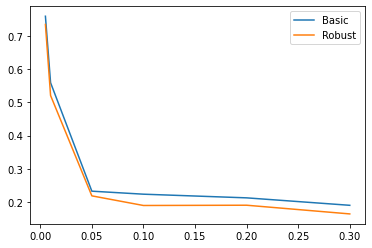

In [29]:
plt.plot(epsilons, np.array(best_model_attack_accs) / best_model_acc, label="Basic")
plt.plot(epsilons, np.array(best_robust_model_attack_accs) / best_robust_model_acc, label="Robust")
plt.legend()
plt.show()